# SMCN for AR prediction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import arma_generate_sample
import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl

from ucn.models import SMCN
from src.trainer import SMCNTrainer
from src.dataset import ARMADataset

%load_ext autoreload
%autoreload 2

!rm -r lightning_logs/*

In [2]:
def plot_range(array, label=None):
    mean = array.mean(axis=-1)
    std = array.std(axis=-1)

    plt.plot(mean, label=label)
#     plt.fill_between(np.arange(len(array)), mean - std, mean + std, alpha=.3)
    plt.fill_between(np.arange(len(array)), array.min(axis=-1), array.max(axis=-1), alpha=.3)
    
def compare_stuff(model):
    print("Sigma_x:\t", model._sigma_x.diag().detach().square().numpy().squeeze().round(2), f"\t({sigma_x})")
    print("Sigma_y:\t", model._sigma_y.diag().detach().square().numpy().squeeze().round(2), f"\t({sigma_y})")
    print("a:\t\t", model._g._linear.weight.detach().numpy().squeeze().round(2), f"\t({b})")
    print("b:\t\t", model._f._linear.weight.detach().numpy().squeeze().round(2), "\t(1)")

## Generate ARMA model and observations

Text(0.5, 1.0, 'ARMA model')

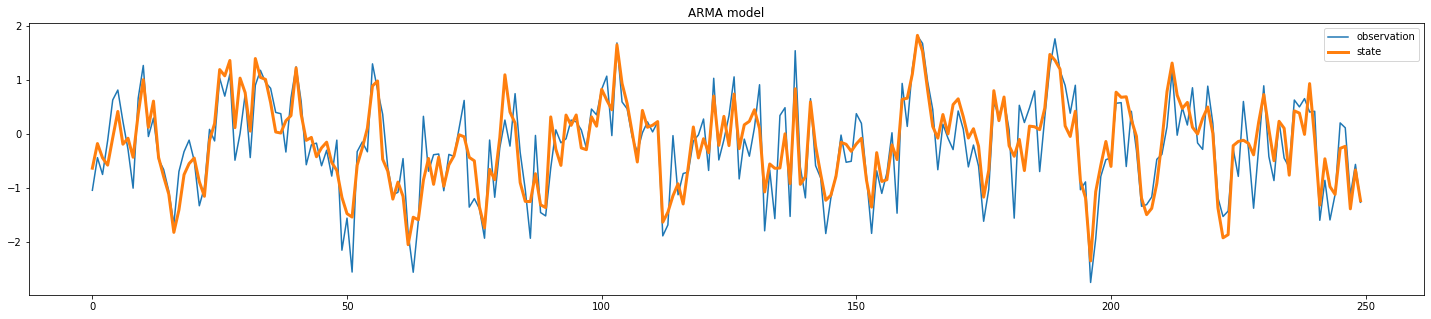

In [3]:
b = 0.75

sigma_x = 0.6
sigma_y = 0.2

n_obs = 10000

arparams = np.array([b])
maparams = np.array([0])

arparams = np.r_[1, -arparams]
maparams = np.r_[1, maparams]
x_arma = arma_generate_sample(arparams, maparams, n_obs, scale=sigma_x)
# x_arma_range = x_arma.max() - x_arma.min()
# x_arma = (x_arma - x_arma.min()) / x_arma_range

y_arma = x_arma + np.random.multivariate_normal((0,),
                                                np.diag([sigma_y]),
                                                size=len(x_arma)).squeeze()
# y_arma_range = y_arma.var()
# y_arma = (y_arma - y_arma.mean()) / y_arma_range 


plt.figure(figsize=(25, 5))
plt.plot(y_arma[:250], label='observation')
plt.plot(x_arma[:250], lw=3, label='state')
plt.legend()
plt.title('ARMA model')

## SMCN Model

In [4]:
d_emb = 1
d_out = 1
N = 50

model = SMCN(d_emb, d_out, n_particles=N)

## Training

#### Dataset

In [5]:
T = 25
batch_size = 8
epochs = 30

dataset = ARMADataset(y_arma,
                      torch.zeros(len(y_arma), d_emb),
                      T)
dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        num_workers=4,
                        shuffle=True
                       )

### Training loop

In [6]:
# model = SMCN(d_emb, d_out, n_particles=N)
compare_stuff(model)

train_model = SMCNTrainer(model)
trainer = pl.Trainer(max_epochs=epochs, gpus=0)
trainer.fit(train_model, dataloader)

compare_stuff(model)

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/home/mrmojo/Code/these/uncertaintyQuantification/.env/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)

  | Name   | Type | Params
--------------------------------
0 | _model | SMCN | 4     
--------------------------------
4         Trainable params
0         Non-trainable params
4         Total params


Sigma_x:	 0.17 	(0.6)
Sigma_y:	 0.34 	(0.2)
a:		 0.88 	(0.75)
b:		 1.0 	(1)
Epoch 29: 100%|██████████| 50/50 [00:02<00:00, 22.92it/s, loss=0.0115, v_num=0]
Sigma_x:	 0.04 	(0.6)
Sigma_y:	 0.33 	(0.2)
a:		 0.81 	(0.75)
b:		 2.67 	(1)


## Visualization

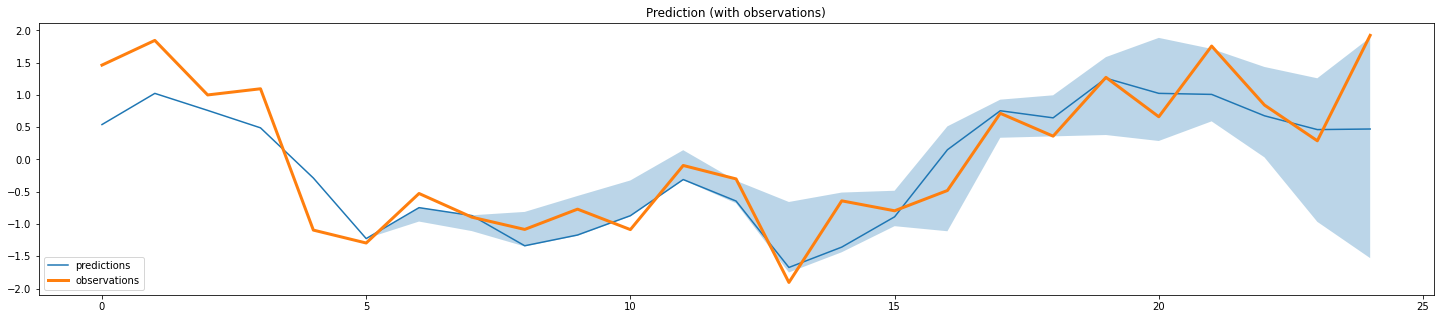

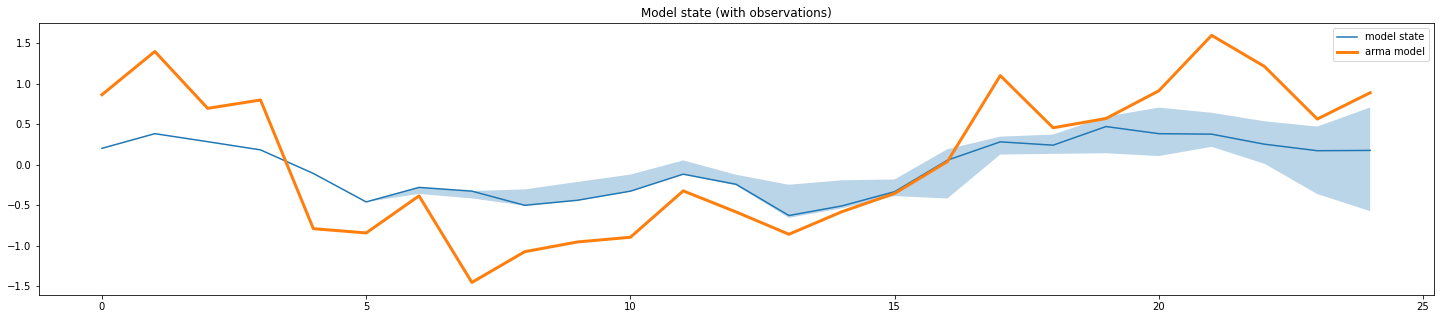

In [7]:
# Sample random time index
idx = np.random.randint(len(x_arma)-T)
x = x_arma[idx:idx+T]
y = y_arma[idx:idx+T]
u = torch.zeros((T, 1, d_emb))

# Run inference with observations
with torch.no_grad():
    netout = model(u, noise=True, y=torch.Tensor(y).view(-1, 1))

netout = SMCN.smooth_pms(netout, model.I)
particules = SMCN.smooth_pms(model.particules, model.I)

netout = netout.detach().numpy().squeeze()
particules = particules.detach().numpy().squeeze()

plt.figure(figsize=(25, 5))
plot_range(netout, label='predictions')
plt.plot(y, lw=3, label='observations')
plt.title('Prediction (with observations)')
plt.legend()

plt.figure(figsize=(25, 5))
plot_range(particules, label='model state')
plt.plot(x, lw=3, label='arma model')
plt.title('Model state (with observations)')
plt.legend()

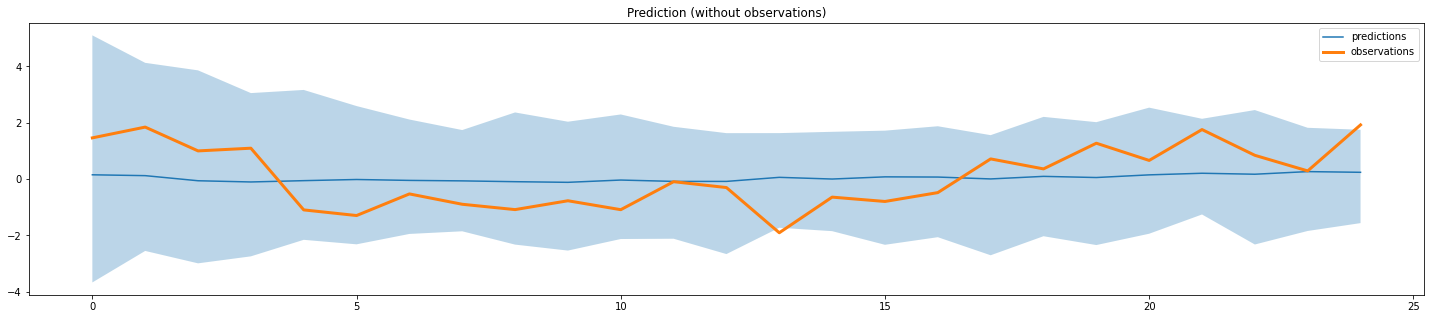

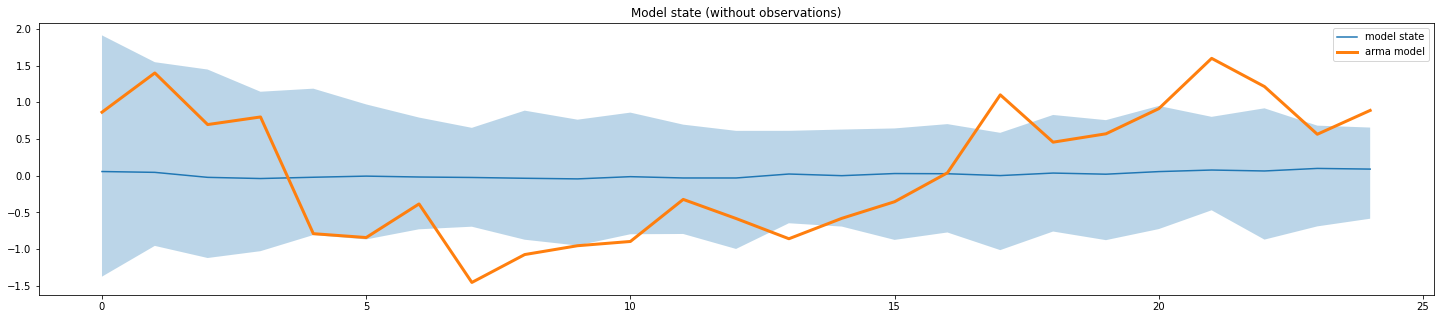

In [8]:
# Run inference withtout observation
with torch.no_grad():
    netout = model(u, noise=True)

netout = netout.detach().numpy().squeeze()
particules = model.particules.detach().numpy().squeeze()

plt.figure(figsize=(25, 5))
plot_range(netout, label='predictions')
plt.plot(y, lw=3, label='observations')
plt.title('Prediction (without observations)')
plt.legend()

plt.figure(figsize=(25, 5))
plot_range(particules, label='model state')
plt.plot(x, lw=3, label='arma model')
plt.title('Model state (without observations)')
plt.legend()